# Data Processing and Predictive Modeling

In this notebook data will be processed for use in predictive models.  Two models will be trained and tested to determine which model has the best performance.  The models will be used to determine the key features that affect user retention.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load data
df = pd.read_csv('clean_data', index_col=0)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


The signup date and last trip date are not important and can be dropped.  The signup date is relatively the same for all users in this dataset (all signed up in January 2014).  The last trip date was used to determine whether a customer was retained or not so this information is now represented in a different way.

In [3]:
# Drop the last_trip_date and signup_date columns
df.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

In [4]:
# Look at dtypes
df.dtypes

city                       object
trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
retained                    int64
dtype: object

In [5]:
# One-hot encode the categorical features
df = pd.get_dummies(df, columns=['city', 'phone', 'ultimate_black_user'])
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


# Train Test Split

In [6]:
# Create train/test split.  X will be all data except retained (what will be predicted). Y will be retained.
X = df.drop(columns='retained', axis=1)
y = df['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35760, 14) (11920, 14) (35760,) (11920,)


# Modeling

Two models will be created to predict user retention.  One will be a Random Forest classifier and the other will be a deep neural network.

### Random Forest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [8]:
# Initiate decision tree
rf = RandomForestClassifier(random_state=10)
print(rf)

RandomForestClassifier(random_state=10)


In [9]:
# Perform an initial 5-fold cross validation
all_accuracies = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=5)
print(all_accuracies)

[0.75545302 0.74930089 0.75769016 0.75251678 0.7560123 ]


In [10]:
# print the average accuracy and the std for the trees
print('The average accuracy is ' + str(all_accuracies.mean()*100) + '%')
print('The std is ' + str(all_accuracies.std()*100) + '%')

The average accuracy is 75.41946308724835%
The std is 0.296209455858283%


In [11]:
# Define the parameters to be tuned
grid_param = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

# Initiate grid search
gd_sr = GridSearchCV(estimator=rf,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

# Fit to the training data
gd_sr.fit(X_train, y_train)

# Print the best parameters
best_parameters = gd_sr.best_params_
print(best_parameters)

# Print the best accuracy
best_result = gd_sr.best_score_
print('The best accuracy was ' + str(best_result*100) + '%')

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 400}
The best accuracy was 75.57885906040269%


In [12]:
# Initialize and fit new rf model with best params
rf_best = RandomForestClassifier(n_estimators=300, bootstrap=True, criterion='entropy')
rf_best.fit(X_train, y_train)

# Make predictions
y_pred = rf_best.predict(X_test)

In [13]:
# Print accuracy
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7476510067114094


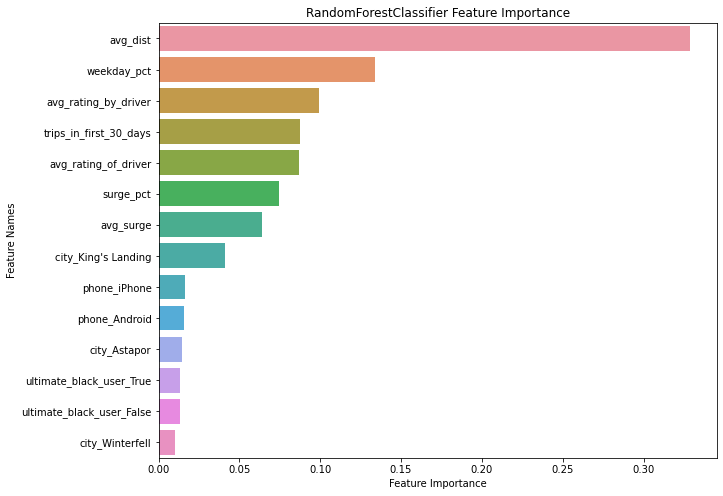

In [14]:
# Create dataframe for feature importance
feature_importance = np.array(rf_best.feature_importances_)
feature_names = np.array(X_train.columns)
feature_df = pd.DataFrame({'feature_names':feature_names, 'feature_importance':feature_importance})

# Sort dataframe by feature importance
feature_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10,8))
sns.barplot(x=feature_df['feature_importance'], y=feature_df['feature_names'])
plt.title('RandomForestClassifier Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.show();

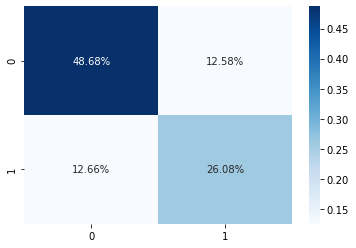

In [15]:
# Visualize Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, 
            fmt='.2%', cmap='Blues');

**Random Forest Conclusions:**

The RandomForestClassifier had an accuracy of about 75%.

The test set was 38.66% retained users and 61.34% not retained users. The model predicted 38.74% retained and 61.26% not retained, but approximately 12.6% in each class was incorrectly predicted.

The confusion matrix shows that there was almost an equal split between false positives (users predicted as retained that were in fact not retained) and false negatives (users predicted as not retained that were in fact retained).

### Deep Neural Network



In [16]:
from keras.models import Sequential
from keras.layers import Dense

In [17]:
X_train.shape

(35760, 14)

In [18]:
# Define the keras model
model = Sequential()
model.add(Dense(12, input_dim=14, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [19]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=10)

Epoch 1/150
3576/3576 [==============================] - 6s 2ms/step - loss: 0.6385 - accuracy: 0.7044
Epoch 2/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.5218 - accuracy: 0.7441
Epoch 3/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.5167 - accuracy: 0.7490
Epoch 4/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.5154 - accuracy: 0.7516
Epoch 5/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.5121 - accuracy: 0.7534
Epoch 6/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.5106 - accuracy: 0.7516
Epoch 7/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.5082 - accuracy: 0.7553
Epoch 8/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.5074 - accuracy: 0.7539
Epoch 9/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.5061 - accuracy: 0.7570
Epoch 10/150
3576/3576 [==============================] - 5s 1ms/step - l

3576/3576 [==============================] - 5s 1ms/step - loss: 0.4907 - accuracy: 0.7654
Epoch 79/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.4906 - accuracy: 0.7652
Epoch 80/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.4898 - accuracy: 0.7662
Epoch 81/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.4905 - accuracy: 0.7637
Epoch 82/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.4903 - accuracy: 0.7642
Epoch 83/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.4900 - accuracy: 0.7661
Epoch 84/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.4903 - accuracy: 0.7641
Epoch 85/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.4899 - accuracy: 0.7637
Epoch 86/150
3576/3576 [==============================] - 5s 1ms/step - loss: 0.4905 - accuracy: 0.7658: 0s - loss: 0.4906 - accu
Epoch 87/150
3576/3576 [===========================

In [21]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

1118/1118 [==============================] - 2s 1ms/step - loss: 0.4935 - accuracy: 0.7619
Accuracy: 76.19


In [22]:
# make class predictions with the model
y_pred = (model.predict(X_test) > 0.5).astype(int)

In [23]:
# Print accuracy
print('Accuracy:', metrics.accuracy_score(y_test, y_pred)*100, '%')

Accuracy: 75.67114093959731 %


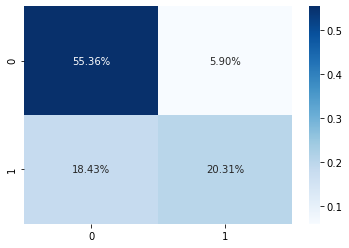

In [24]:
# Visualize Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, 
            fmt='.2%', cmap='Blues');

**Deep Neural Network Conclusions:**

The Keras model had an accuracy of about 76%, just slightly better than the RandomForestClassifier.

Though it had higher accuracy overall, it tended to predict more false positives (users predicted as retained that were in fact not retained) and fewer false negatives (users predicted as not retained that were in fact retained).

This model did much better at predicting not retained users than retained users, which may be of more value to Ultimate since it would show them which users are likely to stop using their service.  However, this could be due to the model's tendency to overpredict not retained.  Since there are more not retained users in the train and test set than there are retained users, the model can overpredict not retained and still have a fairly high accuracy.

# Key Insights

Using either of the two models, Ultimate can predict with approximately 75% accuracy whether users will be retained or not. Ultimate can use this prediction to offer rewards, discounts, or other incentives to users who are predicted to stop using the service. This could encourage inactive users to continue using the service.

If Ultimate were to take this approach, it would be in their best interest to use the RandomForestClassifier model because it had a lower percentage of false negatives (users predicted as not retained that were in fact retained).  If the deep neural network was used Ultimate would end up offering incentives to more users who were actually retained.  By using the model with fewer false negatives, Ultimate would not be giving as many unecessary incentives, meaning incentives given to people who do not need an incentive to continue using the service.